<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Read-data" data-toc-modified-id="Read-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read data</a></span></li><li><span><a href="#Evaluation-metrics" data-toc-modified-id="Evaluation-metrics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Evaluation metrics</a></span></li><li><span><a href="#Experimental-settings" data-toc-modified-id="Experimental-settings-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Experimental settings</a></span></li><li><span><a href="#Run-training-and-testing" data-toc-modified-id="Run-training-and-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Run training and testing</a></span><ul class="toc-item"><li><span><a href="#load-the-best-model-from-training-checkpoints" data-toc-modified-id="load-the-best-model-from-training-checkpoints-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>load the best model from training checkpoints</a></span></li><li><span><a href="#or-load-a-pretrained-model" data-toc-modified-id="or-load-a-pretrained-model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>or load a pretrained model</a></span></li></ul></li><li><span><a href="#Visualize-the-estimation-results" data-toc-modified-id="Visualize-the-estimation-results-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize the estimation results</a></span></li></ul></div>

In [1]:
import numpy as np
import copy
import torch
import torch.optim as optim
from torch import nn
from datasets import metr_La_processing, TraDataLoader, TeDataLoader
from loss import masked_rmse, masked_mae
import matplotlib.pyplot as plt
import utils as ut
from utils import load_metr_la_rdata, get_normalized_adj, get_Laplace, calculate_random_walk_matrix,test_error

from __future__ import division
import matplotlib.pyplot as plt
import random
import pandas as pd
import pickle
import copy

from STCAGCN_model import STCAGCN

## Read data

In [2]:
#PeMs adjacent matrix
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data


sensor_ids, sensor_id_to_ind,A = load_pickle("data/PeMS-Bay-2018/adj_mx_bay.pkl")
A_re = np.load('data/PeMS-Bay-2018/adj_mx_bay_re.npy')
np.fill_diagonal(A_re,1)

#extract the lane number information
#Sensors ['401495', '402288', '402289', '402368', '402369', '404554'] doesn't have observations at all.
meta_df = pd.read_csv('data/PeMS-Bay-2018/d04_text_meta_2021_10_16.txt',delimiter='\t')
lanes = {s: 1 for s in sensor_ids} #default value for missing sensor is 1
for s_id in sensor_ids:
    if int(s_id) in meta_df.ID.values:
        lanes[s_id] = meta_df[meta_df.ID==int(s_id)].Lanes.values[0]
lanes_mat = np.zeros(A.shape[0],)
for k,v in lanes.items():
    lanes_mat[sensor_id_to_ind[k]] = v
    
X = np.load("data/PeMS-Bay-2018/PEMS_bay_2018.npy")
#preprocessing the missing values in raw speed and volume data
missing_index = np.where(X[:,0,:].transpose().sum(axis=1)==0)[0]
for i in missing_index:
    X[:,1,i] = (X[:,1,i-288]+X[:,1,i+288])/2
    X[:,0,i] = (X[:,0,i-288]+X[:,0,i+288])/2

volume_mat_ = X.astype(np.float32)[288*28:288*28*2,:, 0]
speed_mat_ = X.astype(np.float32)[288*28:288*28*2,:, 1]

##5min interval
split_line1 = int(volume_mat_.shape[0] * 0.7)
training_set = volume_mat_[:split_line1,:]
test_set = volume_mat_[split_line1:,:]
speed_mat_train = speed_mat_[:split_line1,:]
speed_mat_test = speed_mat_[split_line1:,:]      # split the training and test period

#delete invalid sensors
valid_sensors = np.where(test_set.sum(axis=0)!=0)[0]
training_set = training_set[:,valid_sensors]
A = A[:,valid_sensors][valid_sensors,:]
lanes_mat = lanes_mat[valid_sensors]
test_set = test_set[:,valid_sensors]
speed_mat_train = speed_mat_train[:,valid_sensors]
speed_mat_test = speed_mat_test[:,valid_sensors]


##normalize the input traffic volume by lane numbers
training_set = (training_set/lanes_mat).astype('float32')
test_set = (test_set/lanes_mat).astype('float32')

print(training_set.shape)
print(test_set.shape)

(5644, 325)
(2420, 325)


## Evaluation metrics

In [3]:
def compute_MAE(X_masked,X_true,X_hat): #Only calculate the errors on the masked and nonzero positions
    pos_test = np.where((X_true != 0) & (X_masked == 0))
    MAE = np.sum(abs(X_true[pos_test]-X_hat[pos_test]))/X_true[pos_test].shape[0]
    
    return MAE


def compute_RMSE(X_masked,X_true,X_hat):
    pos_test = np.where((X_true != 0) & (X_masked == 0))
    RMSE = np.sqrt(((X_true[pos_test]-X_hat[pos_test])**2).sum()/X_true[pos_test].shape[0])
    
    return RMSE


def compute_MAPE(X_masked,X_true,X_hat): 
    pos_test = np.where((X_true != 0) & (X_masked == 0))
    MAPE = np.sum(np.abs(X_true[pos_test]-X_hat[pos_test]) / X_true[pos_test]) / X_true[pos_test].shape[0]
    
    return MAPE


def compute_WMAPE(X_masked,X_true,X_hat):
    pos_test = np.where((X_true != 0) & (X_masked == 0))
    WMAPE = np.sum(np.abs(X_true[pos_test]-X_hat[pos_test])) / np.sum(X_true[pos_test])
    return WMAPE

## Experimental settings

In [4]:
#50% coverage rate
n_o_n_m = 160 #sampled space dimension
K=1
#number of mask node during training
n_m = 80
N_u = 160 #target locations, N_u locations will be deleted from the training data
learning_rate = 5e-4#1e-3
Max_episode = 300
channels = 128
t_kernel = 3 # the length of temporal convolution kernel
batch_size = 32
seq_length = 24 # INput length of the sequence

rand = np.random.RandomState(0) # Fixed random output, just an example when seed = 0.
unknow_set = rand.choice(list(range(0,training_set.shape[1])),N_u,replace=False)
unknow_set = set(unknow_set)
full_set = set(range(0,325))        
know_set = full_set - unknow_set
training_set_s = training_set[:, list(know_set)]   # get the training data in the sample time period
speed_mat_train_s = speed_mat_train[:, list(know_set)]
speed_mat_s = speed_mat_[:, list(know_set)]
E_maxvalue = training_set_s.max() #the max value from experience

A_re_s = A_re[:, list(know_set)][list(know_set), :]

In [5]:
import scipy.sparse as sp

def calculate_asym_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    with np.errstate(divide='ignore'):
        d_inv = np.power(rowsum, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.
    d_mat= sp.diags(d_inv)
    return d_mat.dot(adj).astype(np.float32).todense()

def test_error_record(STmodel,unknow_set, test_data, adj, E_maxvalue, max_norm,Missing0,device,speed_adj_or_data_test):
    unknow_set = set(unknow_set)
    seq_length = STmodel.time_dimension
    test_omask = np.ones(test_data.shape)
    adpt_adj_list = []
    if Missing0 == True:
        test_omask[test_data == 0] = 0
    test_inputs = (test_data * test_omask).astype('float32')

    missing_index = np.ones(np.shape(test_data))
    missing_index[:, list(unknow_set)] = 0
    missing_index_s = missing_index
    o = np.zeros([test_inputs.shape[0]//seq_length*seq_length, test_inputs.shape[1]]) #Separate the test data into several h period

    for i in range(0, test_data.shape[0]//seq_length*seq_length, seq_length): #test batch size is 1
        inputs = test_inputs[i:i+seq_length, :]
        missing_inputs = missing_index_s[i:i+seq_length, :]
        T_inputs = inputs*missing_inputs
        T_inputs = T_inputs/E_maxvalue
        T_inputs = np.expand_dims(T_inputs, axis = 0)
        T_inputs = torch.from_numpy(T_inputs.astype('float32')).to(device)
        T_inputs = torch.unsqueeze(T_inputs, 1)
        speed_data_feed_test = speed_adj_or_data_test[i:i+seq_length, :]   
        speed_data_feed_test = np.expand_dims(speed_data_feed_test, axis = 0)
        speed_data_feed_test = torch.from_numpy(speed_data_feed_test.astype('float32')).to(device)/max_norm
        A_qt = torch.from_numpy(calculate_asym_adj(adj).astype('float32')).to(device)
        A_ht = torch.from_numpy(calculate_asym_adj(adj.T).astype('float32')).to(device)
        A_q0 = adj.copy()
        A_h0 = adj.copy()
        row,col = np.diag_indices_from(A_h0)
        A_q0[row,col] = 0
        A_h0[row,col] = 0
        A_q0 = torch.from_numpy(calculate_asym_adj(A_q0).astype('float32')).to(device)
        A_h0 = torch.from_numpy(calculate_asym_adj(A_h0.T).astype('float32')).to(device)
        
        imputation,adpt_adj_i_af,adt_adj_i_nm = STmodel(T_inputs, A_qt, A_ht,A_q0,A_h0,speed_data_feed_test)
        adpt_adj_list.append(adt_adj_i_nm.detach().cpu().numpy())
        imputation = torch.squeeze(imputation, 1)
        imputation = imputation.data.cpu().numpy()
        o[i:i+seq_length, :] = imputation[0, :, :]
        
    o = o*E_maxvalue
    truth = test_inputs[0:test_data.shape[0]//seq_length*seq_length]
    o[missing_index_s[0:test_data.shape[0]//seq_length*seq_length] == 1] = truth[missing_index_s[0:test_data.shape[0]//seq_length*seq_length] == 1]
    test_mask =  1 - missing_index_s[0:test_data.shape[0]//seq_length*seq_length]
    if Missing0 == True:
        test_mask[truth == 0] = 0
        o[truth == 0] = 0
    o_ = o[:,list(unknow_set)]
    truth_ = truth[:,list(unknow_set)]
    test_mask_ = test_mask[:,list(unknow_set)]
    
    MAE = np.sum(np.abs(o_ - truth_))/np.sum(test_mask_)
    RMSE = np.sqrt(np.sum((o_ - truth_)*(o_ - truth_))/np.sum( test_mask_) )
    MAPE = np.sum(np.abs(o_ - truth_)/(truth_ + 1e-5))/np.sum( test_mask_)
    return MAE, RMSE, MAPE, o, adpt_adj_list

## Run training and testing

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
STmodel = STCAGCN(seq_length, K,in_variables=1,channels=channels,t_kernel=t_kernel)  # The graph neural networks
STmodel.to(device)
criterion = nn.L1Loss()

optimizer = optim.Adam(STmodel.parameters(), lr=learning_rate)
RMSE_list = []
MAE_list = []
MAPE_list = []
adpt_adj_list = []
max_norm = speed_mat_train_s.max()  


for epoch in range(Max_episode):
    for i in range(training_set.shape[0]//(seq_length * batch_size)):  #using time_length as reference to record test_error
        t_random = np.random.randint(0, high=(training_set_s.shape[0] - seq_length), size=batch_size, dtype='l')
        know_mask = set(random.sample(range(0,training_set_s.shape[1]),n_o_n_m)) #sample n_o + n_m nodes
        feed_batch = []
        speed_data_feed_batch = []
        for j in range(batch_size):
            feed_batch.append(training_set_s[t_random[j]: t_random[j] + seq_length, :][:, list(know_mask)]) #generate 8 time batches
            speed_data_feed_batch.append(speed_mat_train_s[t_random[j]: t_random[j] + seq_length, :][:, list(know_mask)])
        inputs = np.array(feed_batch)
        speed_data_feed_batch = np.array(speed_data_feed_batch)
        inputs_omask = np.ones(np.shape(inputs))
        inputs_omask[inputs == 0] = 0           # We found that there are irregular 0 values for METR-LA, so we treat those 0 values as missing data,
                                                # For other datasets, it is not necessary to mask 0 values
                                                
        missing_index = np.ones((inputs.shape))
        for j in range(batch_size):
            missing_mask = random.sample(range(0,n_o_n_m),n_m) #Masked locations
            missing_index[j, :, missing_mask] = 0
            
        Mf_inputs = inputs * inputs_omask * missing_index / E_maxvalue #normalize the value according to experience
        Mf_inputs = torch.from_numpy(Mf_inputs.astype('float32')).to(device) #(batch_size,num_timesteps, in_nodes)
        Mf_inputs = torch.unsqueeze(Mf_inputs, 1) #(batch_size, in_features, num_timesteps, in_nodes)
        mask = torch.from_numpy(inputs_omask.astype('float32')).to(device)   #The reconstruction errors on irregular 0s are not used for training
        mask = torch.unsqueeze(mask, 1)
        speed_data_feed_batch = torch.from_numpy(speed_data_feed_batch.astype('float32')).to(device)/max_norm
        
        A_dynamic = A_re_s[list(know_mask), :][:, list(know_mask)]   #Obtain the dynamic adjacent matrix
        A_q = torch.from_numpy(calculate_asym_adj(A_dynamic).astype('float32')).to(device)
        A_h = torch.from_numpy(calculate_asym_adj(A_dynamic.T).astype('float32')).to(device)
        A_q0 = A_dynamic.copy()
        A_h0 = A_dynamic.copy()
        row,col = np.diag_indices_from(A_h0)
        A_q0[row,col] = 0
        A_h0[row,col] = 0  ##the first layer is zero-diagnoal
        A_q0 = torch.from_numpy(calculate_asym_adj(A_q0).astype('float32')).to(device)
        A_h0 = torch.from_numpy(calculate_asym_adj(A_h0.T).astype('float32')).to(device)
        
        outputs = torch.from_numpy(inputs/E_maxvalue).to(device) #The label
        outputs = torch.unsqueeze(outputs, 1)
        optimizer.zero_grad()
            
        missing_index = torch.transpose(torch.from_numpy(missing_index.astype('float32')),1,2).to(device) 
        X_res,adt_adj_i,adt_adj_i_nm = STmodel(Mf_inputs, A_q, A_h,A_q0,A_h0,speed_data_feed_batch)   
        
        loss = criterion(X_res*mask, outputs*mask) 
        loss.backward()
        optimizer.step()        #Errors backward
    
    adpt_adj_list.append(adt_adj_i_nm.detach().cpu().numpy())
    MAE_t, RMSE_t, MAPE_t, pems_res,_  = test_error_record(STmodel,unknow_set, 
                                                test_set, A_re,E_maxvalue,max_norm, True,device,speed_mat_test)

    RMSE_list.append(RMSE_t)
    MAE_list.append(MAE_t)
    MAPE_list.append(MAPE_t)
    if epoch%50 == 0:
        print(epoch, MAE_t, RMSE_t, MAPE_t)
    if MAE_t == min(MAE_list):
        best_model = copy.deepcopy(STmodel.state_dict())
idx = MAE_list == min(MAE_list)
print('Best model result:',np.array(MAE_list)[idx],np.array(RMSE_list)[idx],np.array(MAPE_list)[idx])

0 39.54018850162186 57.260538470520096 1.5288697322488867
50 18.211713578255086 39.04738575169095 0.3621793766335491
100 17.995244661169387 39.36794703633022 0.3221991093331277
150 16.25388160769194 37.517761161693734 0.3182724275510062
200 16.208367603075523 37.28571870916696 0.32808823629394585
250 16.377877897046886 37.11258333733122 0.3564326541711124
Best model result: [15.90176552] [37.18615471] [0.31550282]


This process consumes about 15 mins and 5 GB memory on a single GPU device. One can set a smaller batch size to reduce memory cost.

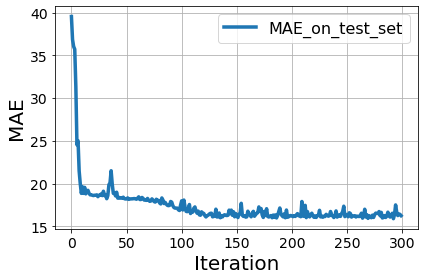

In [7]:
fig,ax = plt.subplots()
ax.plot(MAE_list,label='MAE_on_test_set',linewidth=3.5)
ax.set_xlabel('Iteration',fontsize=20)
ax.set_ylabel('MAE',fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()

### load the best model from training checkpoints

In [8]:
if MAE_t == min(MAE_list):
    print('saved best model at' + str(epoch))
    best_model = copy.deepcopy(STmodel.state_dict())
STmodel.load_state_dict(best_model)

<All keys matched successfully>

### or load a pretrained model

In [9]:
# load saved model, the trained model is in the 'check_point' directory
STmodel_ = torch.load('pems_bay_best_model_128_24.pth')
max_norm = speed_mat_train_s.max()  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
STmodel_.to(device)
MAE_t, RMSE_t, MAPE_t, pems_res,adpt_adj_list  = test_error_record(STmodel_,unknow_set, 
                                                test_set, A_re,E_maxvalue,max_norm, True,device,speed_mat_test)

In [10]:
pems_res[pems_res<0] = 0
volume_hat = pems_res*lanes_mat
volume_true = test_set*lanes_mat
volume_cm = volume_true.copy()
volume_cm[:,list(unknow_set)]=0

mark = pems_res.shape[0]
print(f'MAE:{compute_MAE(volume_cm[:mark,:],volume_true[:mark,:],volume_hat)}')
print(f'RMSE:{compute_RMSE(volume_cm[:mark,:],volume_true[:mark,:],volume_hat)}')
print(f'MAPE:{compute_MAPE(volume_cm[:mark,:],volume_true[:mark,:],volume_hat)}')
print(f'WMAPE:{compute_WMAPE(volume_cm[:mark,:],volume_true[:mark,:],volume_hat)}')

MAE:43.82593746076402
RMSE:65.99208650149313
MAPE:0.3013198671802652
WMAPE:0.19585125623098562


## Visualize the estimation results

In [11]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

clist=['green','yellow','red']
newcmp = LinearSegmentedColormap.from_list('nt',clist)

Text(0.5, 1.0, 'Ground Truth')

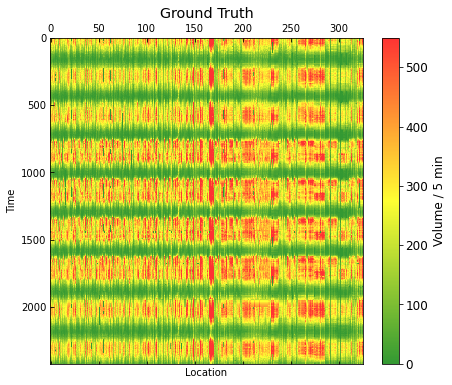

In [12]:
fig,ax = plt.subplots(figsize=(7,6))
plt.rcParams['font.size'] = 12
ax.tick_params(direction = "in")
mt = ax.matshow(volume_true,cmap=newcmp,aspect='auto',vmax=550,alpha=0.8)
plt.colorbar(mt,label='Volume / 5 min')
plt.xlabel('Location')
plt.ylabel('Time')
plt.title('Ground Truth')

Text(0.5, 1.0, 'STCAGCN Estimation')

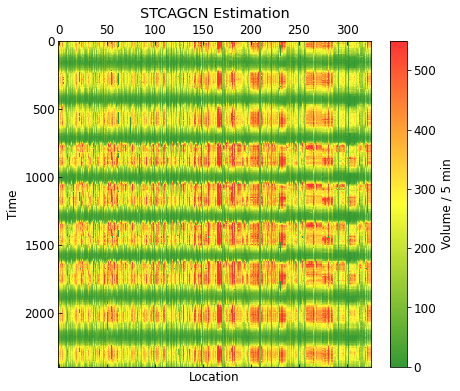

In [13]:
fig,ax = plt.subplots(figsize=(7,6))
plt.rcParams['font.size'] = 12
ax.tick_params(direction = "in")
mt = ax.matshow(volume_hat,cmap=newcmp,aspect='auto',vmax=550,alpha=0.8)
plt.colorbar(mt,label='Volume / 5 min')
plt.xlabel('Location')
plt.ylabel('Time')
plt.title('STCAGCN Estimation')